Simple Propagation

In [3]:
import orekit
from orekit.pyhelpers import setup_orekit_curdir, datetime_to_absolutedate
# orekit.pyhelpers.download_orekit_data_curdir() #run this if you don't have the orekit-data.zip file to download it
vm = orekit.initVM()
setup_orekit_curdir("orekit-data.zip") #Set this path to wherever your orekit-data.zip file is located

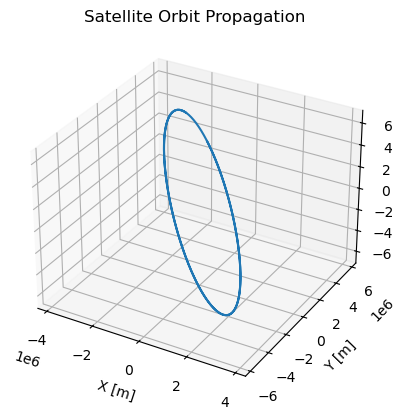

In [5]:
"""
1. Initialize Orekit and load data.
2. Define the initial conditions.
3. Configure force models for the propagator.
4. Perform propagation and visualize results.
"""

# Step 1: Import Required Libraries

from orekit.pyhelpers import datetime_to_absolutedate
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.orbits import CartesianOrbit, OrbitType
from org.orekit.utils import Constants, PVCoordinates, IERSConventions
from org.orekit.propagation.numerical import NumericalPropagator
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
from org.orekit.frames import FramesFactory
from org.orekit.propagation import SpacecraftState
from orekit import JArray_double
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Step 3: Define Initial Conditions
# Define initial position (m) and velocity (m/s) in ECI frame
initial_position = [-1620690.1530842409,2615729.21083149,6120829.369866818,]
initial_velocity = [-3872.165771597047,5607.204834079615,-3424.20599420816]

mass = 1000  # Mass of the spacecraft in kg

# Define start and end dates for propagation
start_date = datetime(2024, 1, 1, 0, 0, 0)  # Start date
end_date = start_date + timedelta(hours=3)  # Propagate for 3 hours

# Step 4: Create Initial Orbit and Propagator
# Convert dates to Orekit AbsoluteDate
initial_date = datetime_to_absolutedate(start_date)
frame = FramesFactory.getEME2000()

# Define the initial orbit
initial_orbit = CartesianOrbit(
    PVCoordinates(
        Vector3D(float(initial_position[0]), float(initial_position[1]), float(initial_position[2])),
        Vector3D(float(initial_velocity[0]), float(initial_velocity[1]), float(initial_velocity[2]))
    ),
    frame,
    initial_date,
    Constants.WGS84_EARTH_MU
)

# Set numerical integrator parameters
min_step = 0.001
max_step = 100.0
initial_step = 60.0
position_tolerance = 1.0  # Tolerance in meters
tolerances = NumericalPropagator.tolerances(position_tolerance, initial_orbit, OrbitType.CARTESIAN)
integrator = DormandPrince853Integrator(min_step, max_step, JArray_double.cast_(tolerances[0]), JArray_double.cast_(tolerances[1]))
integrator.setInitialStepSize(initial_step)

# Create numerical propagator
propagator = NumericalPropagator(integrator)
propagator.setOrbitType(OrbitType.CARTESIAN)

# Step 5: Configure Force Models
from org.orekit.propagation import SpacecraftState

# Add Earth's gravity field to the propagator
gravity_provider = GravityFieldFactory.getNormalizedProvider(12, 12)  # 12x12 gravity model
gravity_force = HolmesFeatherstoneAttractionModel(
    FramesFactory.getITRF(IERSConventions.IERS_2010, False), gravity_provider
)
propagator.addForceModel(gravity_force)

# Create the initial spacecraft state with orbit and mass
initial_state = SpacecraftState(initial_orbit, float(mass))

# Set the initial state for the propagator
propagator.setInitialState(initial_state)

# Step 6: Propagate the Orbit
step_size = 60.0  # Output step size in seconds
current_date = initial_date
results = []

while current_date.compareTo(datetime_to_absolutedate(end_date)) <= 0:
    state = propagator.propagate(current_date)
    position = state.getPVCoordinates().getPosition()
    velocity = state.getPVCoordinates().getVelocity()
    results.append({
        "UTC": current_date.toString(),
        "x": position.getX(), "y": position.getY(), "z": position.getZ(),
        "vx": velocity.getX(), "vy": velocity.getY(), "vz": velocity.getZ()
    })
    current_date = current_date.shiftedBy(step_size)  # Advance by step size

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Step 7: Visualize Results
#plot x,y,z coords in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(df['x'], df['y'], df['z'])
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
plt.title("Satellite Orbit Propagation")
plt.show()


# - Adjust force models by adding more `addForceModel()` calls (e.g., SRP, drag, etc.).
# - Modify step size and tolerances for different accuracies.
# - Experiment with different initial conditions for your coursework scenarios.
